In [11]:
# ==============================================================================
# PHASE 1: STABLE STREAMING MODE (SINGLE GPU)
# ==============================================================================

import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

In [12]:
# --- 1. CONFIGURATION ---
CONF = {
    # Path to your 43k dataset
    "DATASET_PATH": "/kaggle/input/datasets/haytamrais/human-protein-distograms-43k/protein_dataset_human_128x128.npz", 
    "IMG_SIZE": 128,
    "BATCH_SIZE": 16,       # <--- STREAMING SIZE (Tiny batches = No Crashes)
    "LATENT_CHANNELS": 16,  
    "EPOCHS": 30,           
    "LR_G": 1e-4,           
    "LR_D": 4e-4,           
    "KL_WEIGHT": 1e-6,      
    "ADV_WEIGHT": 0.1,      
    "MAX_DIST": 22.0,       
    "SAVE_DIR": "./checkpoints_phase1"
}

os.makedirs(CONF["SAVE_DIR"], exist_ok=True)
# Force Single GPU (Most Stable)
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = torch.device("cuda:0")
    print(f"🚀 Streaming to GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("⚠️ Training on CPU")

🚀 Streaming to GPU: Tesla P100-PCIE-16GB


In [13]:
# --- 2. DATASET (RAM BUFFER) ---
class DistogramDataset(Dataset):
    def __init__(self, npz_path):
        print(f"Loading dataset index from {npz_path}...")
        try:
            # We load to CPU RAM (Cheap), not GPU VRAM (Expensive)
            data = np.load(npz_path)
            self.maps = data['contact_maps'] 
            self.masks = data['masks']
            print(f"✅ Indexed {len(self.maps)} samples.")
        except FileNotFoundError:
            print(f"❌ ERROR: Dataset not found.")
            self.maps = np.zeros((100, 128, 128), dtype=np.float32)
            self.masks = np.ones((100, 128, 128), dtype=np.float32)
        
    def __len__(self):
        return len(self.maps)
    
    def __getitem__(self, idx):
        # Data stays on CPU until this specific item is requested
        dmap = self.maps[idx].astype(np.float32)
        mask = self.masks[idx].astype(np.float32)
        dmap_clamped = np.clip(dmap, 0, CONF['MAX_DIST'])
        dmap_norm = (CONF['MAX_DIST'] - dmap_clamped) / CONF['MAX_DIST']
        dmap_final = dmap_norm * mask
        return torch.tensor(dmap_final).unsqueeze(0), torch.tensor(mask).unsqueeze(0)

In [14]:
# --- 3. MODEL BLOCKS ---
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Conv2d(in_dim, in_dim//8, 1)
        self.key   = nn.Conv2d(in_dim, in_dim//8, 1)
        self.value = nn.Conv2d(in_dim, in_dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1)) 

    def forward(self, x):
        B, C, W, H = x.size()
        proj_query = self.query(x).view(B, -1, W*H).permute(0, 2, 1)
        proj_key   = self.key(x).view(B, -1, W*H)
        energy     = torch.bmm(proj_query, proj_key)
        attention  = F.softmax(energy, dim=-1)
        proj_value = self.value(x).view(B, -1, W*H)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(B, C, W, H)
        return self.gamma * out + x

class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(8, channels), nn.SiLU(), 
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.GroupNorm(8, channels), nn.SiLU(),
            nn.Conv2d(channels, channels, 3, 1, 1),
        )
    def forward(self, x): return x + self.block(x)

In [15]:
# --- 4. NETWORKS ---
class VAE_Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.SiLU(),    
            nn.Conv2d(32, 64, 4, 2, 1), nn.SiLU(),   
            nn.Conv2d(64, 128, 4, 2, 1), nn.SiLU(),  
            ResBlock(128), SelfAttention(128), ResBlock(128),
            nn.GroupNorm(32, 128), nn.SiLU()
        )
        self.to_mu = nn.Conv2d(128, CONF['LATENT_CHANNELS'], 3, 1, 1)
        self.to_logvar = nn.Conv2d(128, CONF['LATENT_CHANNELS'], 3, 1, 1)
    def forward(self, x):
        h = self.net(x)
        return self.to_mu(h), self.to_logvar(h)

class VAE_Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_proj = nn.Conv2d(CONF['LATENT_CHANNELS'], 128, 3, 1, 1)
        self.net = nn.Sequential(
            ResBlock(128), SelfAttention(128),
            nn.Upsample(scale_factor=2), nn.Conv2d(128, 64, 3, 1, 1), nn.GroupNorm(16, 64), nn.SiLU(),
            nn.Upsample(scale_factor=2), nn.Conv2d(64, 32, 3, 1, 1), nn.GroupNorm(8, 32), nn.SiLU(),
            nn.Upsample(scale_factor=2), nn.Conv2d(32, 16, 3, 1, 1), nn.GroupNorm(4, 16), nn.SiLU(),
            nn.Conv2d(16, 1, 3, 1, 1) 
        )
    def forward(self, z):
        x = self.input_proj(z)
        x = self.net(x)
        return torch.sigmoid(x) 

class PatchDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        def block(in_c, out_c, normalize=True):
            layers = [nn.utils.spectral_norm(nn.Conv2d(in_c, out_c, 4, 2, 1))]
            if normalize: layers.append(nn.InstanceNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2))
            return layers
        self.model = nn.Sequential(
            *block(1, 64, normalize=False), *block(64, 128), *block(128, 256),
            nn.Conv2d(256, 1, 4, 1, 1) 
        )
    def forward(self, x): return self.model(x)

In [16]:
# --- 5. INITIALIZATION ---
def get_model_simple():
    # Load directly to the correct device (No switching back and forth)
    enc = VAE_Encoder().to(device)
    dec = VAE_Decoder().to(device)
    disc = PatchDiscriminator().to(device)
    return enc, dec, disc

In [17]:
# --- 6. TRAINING STEP (STREAMING) ---
def train_epoch(enc, dec, disc, loader, opt_G, opt_D, epoch):
    enc.train(); dec.train(); disc.train()
    total_g, total_d = 0, 0
    torch.backends.cudnn.benchmark = True

    for i, (real_imgs, masks) in enumerate(loader):
        # Stream batch to GPU
        real_imgs, masks = real_imgs.to(device), masks.to(device)
        
        # --- Train VAE ---
        opt_G.zero_grad()
        mu, logvar = enc(real_imgs)
        std = torch.exp(0.5 * logvar)
        z = mu + (torch.randn_like(std) * std)
        recon = dec(z)
        
        recon_loss = F.l1_loss(recon * masks, real_imgs * masks)
        kl_loss = (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / real_imgs.size(0)) * CONF['KL_WEIGHT']
        
        fake_logits = disc(recon)
        adv_loss = F.mse_loss(fake_logits, torch.ones_like(fake_logits)) * CONF['ADV_WEIGHT']
        
        g_loss = recon_loss + kl_loss + adv_loss
        g_loss.backward()
        opt_G.step()
        
        # --- Train Discriminator ---
        opt_D.zero_grad()
        real_logits = disc(real_imgs)
        fake_logits_det = disc(recon.detach())
        d_loss = 0.5 * (F.mse_loss(real_logits, torch.ones_like(real_logits)) + F.mse_loss(fake_logits_det, torch.zeros_like(fake_logits_det)))
        d_loss.backward()
        opt_D.step()
        
        total_g += g_loss.item(); total_d += d_loss.item()
        
    return total_g / len(loader), total_d / len(loader)

In [18]:
# --- 7. BRIDGE (SAVE LATENTS) ---
def generate_latent_dataset(encoder, loader, save_path):
    encoder.eval()
    all_latents = []
    print(f"🌉 Bridge: Compressing {len(loader.dataset)} samples...")
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            mu, _ = encoder(imgs)
            all_latents.append(mu.cpu().numpy())
    all_latents = np.concatenate(all_latents, axis=0)
    np.savez_compressed(save_path, latents=all_latents)
    print(f"✅ Saved to {save_path}")

Loading dataset index from /kaggle/input/datasets/haytamrais/human-protein-distograms-43k/protein_dataset_human_128x128.npz...
✅ Indexed 43179 samples.
📊 Split: Train=34543 | Val=4317 | Test=4319

🔥 Starting Training (Streaming Mode)...
Epoch 1/30 | Train G: 0.1147 | Val L1: 0.0403
Epoch 2/30 | Train G: 0.1062 | Val L1: 0.0314
Epoch 3/30 | Train G: 0.1053 | Val L1: 0.0298
Epoch 4/30 | Train G: 0.1024 | Val L1: 0.0255
Epoch 5/30 | Train G: 0.1015 | Val L1: 0.0250
Epoch 6/30 | Train G: 0.1016 | Val L1: 0.0239
Epoch 7/30 | Train G: 0.1026 | Val L1: 0.0239
Epoch 8/30 | Train G: 0.1031 | Val L1: 0.0245
Epoch 9/30 | Train G: 0.1040 | Val L1: 0.0232
Epoch 10/30 | Train G: 0.1048 | Val L1: 0.0231


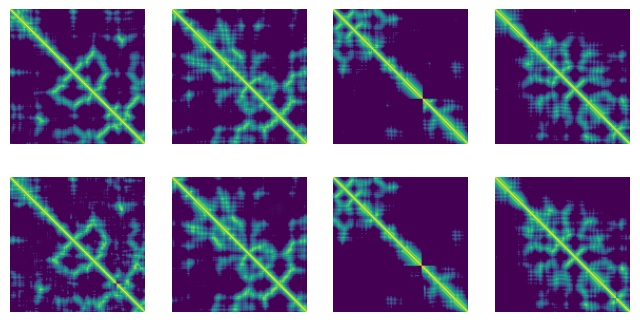

Epoch 11/30 | Train G: 0.1052 | Val L1: 0.0236
Epoch 12/30 | Train G: 0.1055 | Val L1: 0.0226
Epoch 13/30 | Train G: 0.1057 | Val L1: 0.0234
Epoch 14/30 | Train G: 0.1057 | Val L1: 0.0229
Epoch 15/30 | Train G: 0.1066 | Val L1: 0.0225
Epoch 16/30 | Train G: 0.1070 | Val L1: 0.0223
Epoch 17/30 | Train G: 0.1074 | Val L1: 0.0229
Epoch 18/30 | Train G: 0.1073 | Val L1: 0.0232
Epoch 19/30 | Train G: 0.1075 | Val L1: 0.0223
Epoch 20/30 | Train G: 0.1078 | Val L1: 0.0231


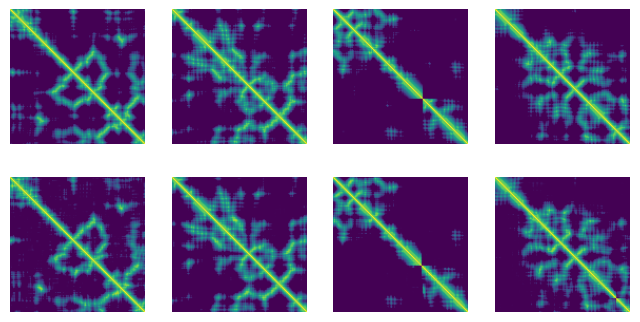

Epoch 21/30 | Train G: 0.1080 | Val L1: 0.0220
Epoch 22/30 | Train G: 0.1081 | Val L1: 0.0232
Epoch 23/30 | Train G: 0.1082 | Val L1: 0.0228
Epoch 24/30 | Train G: 0.1081 | Val L1: 0.0228
Epoch 25/30 | Train G: 0.1085 | Val L1: 0.0227
Epoch 26/30 | Train G: 0.1086 | Val L1: 0.0242
Epoch 27/30 | Train G: 0.1088 | Val L1: 0.0240
Epoch 28/30 | Train G: 0.1089 | Val L1: 0.0223
Epoch 29/30 | Train G: 0.1089 | Val L1: 0.0218
Epoch 30/30 | Train G: 0.1089 | Val L1: 0.0223


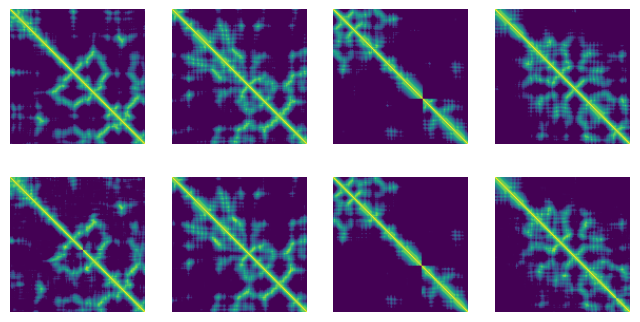

✅ DONE. Time: 42.4 mins
🌉 Bridge: Compressing 34543 samples...
✅ Saved to latents_train.npz
🌉 Bridge: Compressing 4317 samples...
✅ Saved to latents_val.npz
🎉 Ready for Phase 2!


In [19]:
# --- 8. MAIN EXECUTION ---
if __name__ == "__main__":
    # Load & Split
    full_ds = DistogramDataset(CONF['DATASET_PATH'])
    total_size = len(full_ds)
    
    if total_size > 0:
        train_sz = int(0.8 * total_size)
        val_sz = int(0.1 * total_size)
        test_sz = total_size - train_sz - val_sz
        
        train_ds, val_ds, test_ds = random_split(full_ds, [train_sz, val_sz, test_sz], generator=torch.Generator().manual_seed(42))
        print(f"📊 Split: Train={len(train_ds)} | Val={len(val_ds)} | Test={len(test_ds)}")
        
        # pin_memory=True speeds up the "Stream" from CPU to GPU
        train_loader = DataLoader(train_ds, batch_size=CONF['BATCH_SIZE'], shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
        val_loader = DataLoader(val_ds, batch_size=CONF['BATCH_SIZE'], shuffle=False, num_workers=2, pin_memory=True, drop_last=True)
        
        # Init Models
        enc, dec, disc = get_model_simple()
        
        opt_G = optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=CONF['LR_G'], betas=(0.5, 0.9))
        opt_D = optim.Adam(disc.parameters(), lr=CONF['LR_D'], betas=(0.5, 0.9))
        
        print("\n🔥 Starting Training (Streaming Mode)...")
        start_time = time.time()
        
        for epoch in range(CONF['EPOCHS']):
            g_loss, d_loss = train_epoch(enc, dec, disc, train_loader, opt_G, opt_D, epoch)
            
            # Validation
            enc.eval(); dec.eval()
            val_loss = 0
            with torch.no_grad():
                for real_imgs, masks in val_loader:
                    real_imgs, masks = real_imgs.to(device), masks.to(device)
                    recon = dec(enc(real_imgs)[0])
                    val_loss += F.l1_loss(recon * masks, real_imgs * masks).item()
            avg_val = val_loss / len(val_loader)
            
            print(f"Epoch {epoch+1}/{CONF['EPOCHS']} | Train G: {g_loss:.4f} | Val L1: {avg_val:.4f}")
            
            if (epoch+1) % 10 == 0:
                torch.save(enc.state_dict(), f"{CONF['SAVE_DIR']}/encoder_ep{epoch+1}.pth")
                
                # Visual Check
                with torch.no_grad():
                    sample = next(iter(val_loader))[0][:4].to(device)
                    recon = dec(enc(sample)[0])
                    fig, ax = plt.subplots(2, 4, figsize=(8, 4))
                    for i in range(4):
                        ax[0,i].imshow(sample[i,0].cpu(), cmap='viridis'); ax[0,i].axis('off')
                        ax[1,i].imshow(recon[i,0].cpu(), cmap='viridis'); ax[1,i].axis('off')
                    plt.show()

        print(f"✅ DONE. Time: {(time.time()-start_time)/60:.1f} mins")

        # --- RUN BRIDGE ---
        generate_latent_dataset(enc, train_loader, "latents_train.npz")
        generate_latent_dataset(enc, val_loader, "latents_val.npz")
        print("🎉 Ready for Phase 2!")
    else:
        print("⚠️ DATASET NOT FOUND.")

In [20]:
# Save the Decoder weights (Crucial for Phase 2)
torch.save(dec.state_dict(), "decoder_final.pth")
print("✅ Decoder saved! Now you are safe.")

✅ Decoder saved! Now you are safe.
